In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd6"
base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

dvs = ["areal_density", "n_craters_in_study_region", "z", "za"]
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]

In [3]:
sample_size = 1000

train_df = pd.read_csv(f"{base_path}/post_saturation_sample_{sample_size}.csv")

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/post_saturation_in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/post_saturation_sample_{sample_size}.csv")
]

metric = "areal_density"

### Linear regression models

In [4]:
def fit_and_report_statsmodels_model(model_class,
                                     X_train,
                                     y_train,
                                     X_tests,
                                     y_tests,
                                     model_name,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = model_class(y_train_transformed, X_train).fit()
    print(model.summary())

    y_pred = inverse_transform(model.predict(X_train))
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = inverse_transform(model.predict(X_test))
        rmse = mean_squared_error(y_pred, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred, y_test)
        print(f"Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")

        y_pred_mean_model = [y_train.mean()] * len(y_test)
        rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
        print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model

#### Checking scatterplots

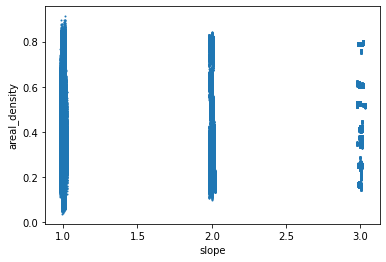

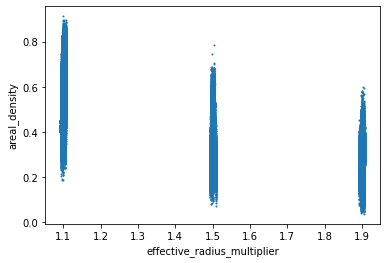

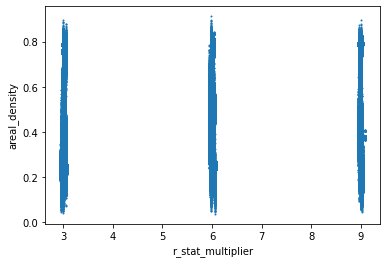

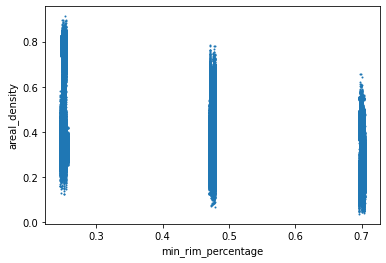

In [5]:
series = train_df[metric]

for iv in ivs:
    plt.scatter(train_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

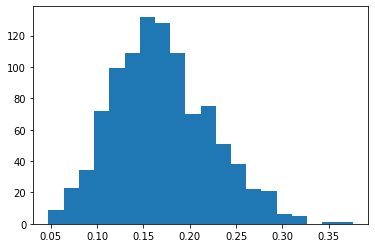

In [6]:
plt.hist(train_df[train_df.simulation_id == 26][metric], bins=20)
plt.show()

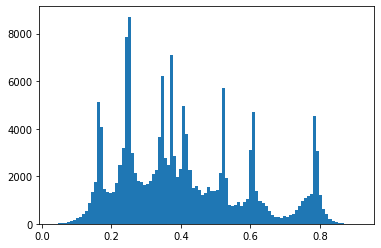

In [7]:
plt.hist(train_df[metric], bins=100)
plt.show()

### Baseline Linear Regression Model

                            OLS Regression Results                            
Dep. Variable:          areal_density   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 4.120e+05
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:17   Log-Likelihood:             2.3955e+05
No. Observations:              162710   AIC:                        -4.791e+05
Df Residuals:                  162705   BIC:                        -4.790e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

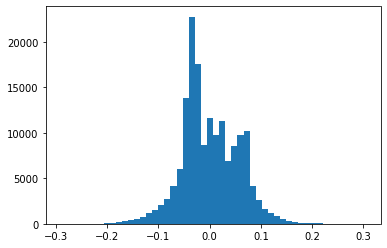

KS test p-value on training residuals: 0.000
AD test on training residuals: 1090.334, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.0563, Test MAPE: 0.1614
Mean model: RMSE: 0.1854, MAPE: 0.3724
*** Test set 2
Test RMSE: 0.0441, Test MAPE: 0.0918
Mean model: RMSE: 0.1202, MAPE: 0.2552


In [8]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

fit_and_report_statsmodels_model(sm.OLS,
                                 sm.add_constant(X_train),
                                 y_train,
                                 [sm.add_constant(x) for x in X_tests],
                                 y_tests,
                                 "LM No Interactions",
                                 transform=lambda x: x,
                                 inverse_transform=lambda x: x)

### With Interactions

                            OLS Regression Results                            
Dep. Variable:          areal_density   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 2.446e+05
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:18   Log-Likelihood:             2.9517e+05
No. Observations:              162710   AIC:                        -5.903e+05
Df Residuals:                  162695   BIC:                        -5.902e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

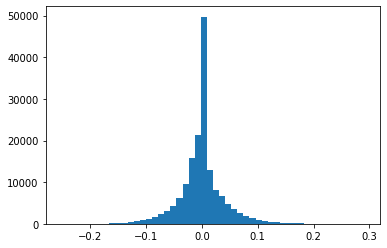

KS test p-value on training residuals: 0.000
AD test on training residuals: 4368.127, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.0403, Test MAPE: 0.0773
Mean model: RMSE: 0.1854, MAPE: 0.3724
*** Test set 2
Test RMSE: 0.0347, Test MAPE: 0.0690
Mean model: RMSE: 0.1202, MAPE: 0.2552


In [9]:
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") for x in X_tests],
                                         y_tests,
                                         "LM With All Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

#### Removing Insignificant Variables

                            OLS Regression Results                            
Dep. Variable:          areal_density   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 8.209e+05
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:19   Log-Likelihood:             2.9191e+05
No. Observations:              162710   AIC:                        -5.838e+05
Df Residuals:                  162705   BIC:                        -5.838e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

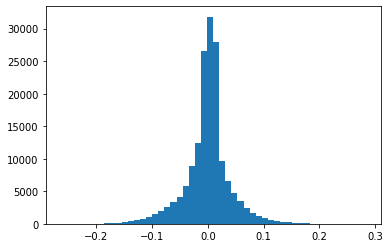

KS test p-value on training residuals: 0.000
AD test on training residuals: 3700.413, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.0412, Test MAPE: 0.0789
Mean model: RMSE: 0.1854, MAPE: 0.3724
*** Test set 2
Test RMSE: 0.0351, Test MAPE: 0.0693
Mean model: RMSE: 0.1202, MAPE: 0.2552


In [10]:
exclude = {
    'effective_radius_multiplier r_stat_multiplier', # p-value
    'slope r_stat_multiplier', # p-value
    'r_stat_multiplier min_rim_percentage', # effect size
    'r_stat_multiplier^2', # effect size
    'r_stat_multiplier', # p-value
    'slope min_rim_percentage', # effect size
    'slope^2', # effect size
    'min_rim_percentage^2', # effect size
    'slope effective_radius_multiplier', # effect size
    'slope', # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") for x in X_tests],
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [11]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

const                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

In [12]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.29823605225858374, 'effective_radius_multiplier min_rim_percentage'),
 (0.3121360394260502, 'effective_radius_multiplier^2'),
 (0.5627913225504463, 'min_rim_percentage'),
 (1.0, 'effective_radius_multiplier'),
 (1.2059794227426894, 'const')]

### Trying with degree=3

In [ ]:
exclude = {
    "r_stat_multiplier min_rim_percentage^2", # p-value
    "r_stat_multiplier^2 min_rim_percentage", # p-value
    "effective_radius_multiplier^3", # p-value
    "slope^3", # p-value
    "slope^2 r_stat_multiplier", # p-value
    "slope r_stat_multiplier min_rim_percentage", # p-value
    "slope r_stat_multiplier min_rim_percentage", # p-value
    "slope effective_radius_multiplier^2", # p-value
    "effective_radius_multiplier^2 r_stat_multiplier", # p-value
    "min_rim_percentage^3", # p-value
    "r_stat_multiplier^3", # p-value
    "effective_radius_multiplier r_stat_multiplier min_rim_percentage", # p-value
    "r_stat_multiplier min_rim_percentage", # p-value
    "slope effective_radius_multiplier r_stat_multiplier", # p-value
    "slope r_stat_multiplier^2", # p-value
    "slope r_stat_multiplier", # p-value
    
    "slope effective_radius_multiplier min_rim_percentage", # effect size
    "effective_radius_multiplier r_stat_multiplier^2", # effect size
    "r_stat_multiplier^2", # p-value
    "effective_radius_multiplier r_stat_multiplier", # p-value
    "r_stat_multiplier", # p-value
    "slope min_rim_percentage^2", # effect size
    "effective_radius_multiplier^2 min_rim_percentage", # effect size
    "effective_radius_multiplier min_rim_percentage^2", # effect size
    "min_rim_percentage^2", # effect size
    "slope^2 min_rim_percentage", # effect size
    "slope^2 effective_radius_multiplier", # effect size
    "slope^2", # effect size
    "slope min_rim_percentage", # effect size
    "slope effective_radius_multiplier", # effect size
    "slope", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") for x in X_tests],
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Using Recursive Feature Elimination With Interactions

In [ ]:
exclude = {}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [ ]:
min_features_to_select = 1 
model = sklearn.linear_model.LinearRegression()
cv = KFold(5)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=15
)
rfecv.fit(X_train, y_train)

In [ ]:
model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train[rfecv.get_feature_names_out()]),
                                         y_train,
                                         [sm.add_constant(x[rfecv.get_feature_names_out()]) for x in X_tests],
                                         y_tests,
                                         "LM With RFE Features")

### Plotting Prediction Intervals

                            OLS Regression Results                            
Dep. Variable:          areal_density   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 8.209e+05
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        13:33:29   Log-Likelihood:             2.9191e+05
No. Observations:              162710   AIC:                        -5.838e+05
Df Residuals:                  162705   BIC:                        -5.838e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

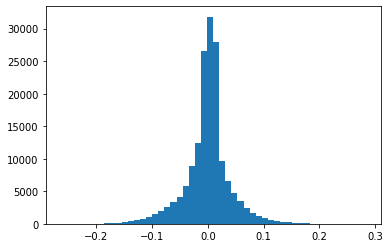

KS test p-value on training residuals: 0.000
AD test on training residuals: 3700.413, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.0412, Test MAPE: 0.0789
Mean model: RMSE: 0.1854, MAPE: 0.3724
*** Test set 2
Test RMSE: 0.0351, Test MAPE: 0.0693
Mean model: RMSE: 0.1202, MAPE: 0.2552


In [13]:
exclude = {
    'effective_radius_multiplier r_stat_multiplier', # p-value
    'slope r_stat_multiplier', # p-value
    'r_stat_multiplier min_rim_percentage', # effect size
    'r_stat_multiplier^2', # effect size
    'r_stat_multiplier', # p-value
    'slope min_rim_percentage', # effect size
    'slope^2', # effect size
    'min_rim_percentage^2', # effect size
    'slope effective_radius_multiplier', # effect size
    'slope', # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") for x in X_tests],
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [14]:
feature_names = [x for x in model.model.exog_names if x != "const"]

In [15]:
# Load up a subset of the test DFs
np.random.seed(123)

sample_cadence = 100
in_ccd_paths = list(Path(base_path).glob("simulation_*.parquet"))
outside_ccd_paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))

In [20]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + dvs + ["simulation_id", "n_craters_added_in_study_region"])
    return df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()


def score_model(model,
                df: pd.DataFrame,
                alphas: list[float],
                metric: str,
                inverse_transform) -> pd.DataFrame:
    X = df[ivs]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    for feature_name in poly_transform.get_feature_names_out():
        pred_df[feature_name] = X[feature_name]
    
    X = X[feature_names].copy()
    y = df[metric]
    
    predictions = inverse_transform(model.get_prediction(sm.add_constant(X, has_constant="add")))
    pred_df["actual"] = list(y)
    pred_df["n_craters"] = list(df.index)
    
    for alpha in alphas:
        ci_lower = predictions.conf_int(obs=True, alpha=alpha*2)[:,0]
        pred_df[f"alpha_{alpha:.2f}"] = inverse_transform(ci_lower)
    
    return pred_df


def score_model_from_parquet_file(model,
                                  parquet_path: Path,
                                  sample_cadence: int,
                                  alphas: list[float],
                                  metric: str,
                                  inverse_transform) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, sample_cadence)
    return score_model(model, df, alphas, metric, inverse_transform)


def score_model_on_multiple_files(model,
                                  parquet_paths: list[Path],
                                  sample_cadence: int,
                                  alphas: list[float],
                                  metric: str,
                                  inverse_transform) -> pd.DataFrame:
    results = []
    for path in parquet_paths:
        scored = score_model_from_parquet_file(model,
                                               parquet_path,
                                               sample_cadence,
                                               alpha,
                                               metric,
                                               inverse_transform)
        results.append(scored)
    
    return pd.concat(results, axis=0)
        
import time
    
def plot_holdout_sim_ci(model,
                        alphas: list[float],
                        parquet_path: Path,
                        sample_cadence: int,
                        metric: str,
                        inverse_transform):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, alphas, metric, inverse_transform)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

    ns_max = 100000
    plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
             pred_df[metric].iloc[:ns_max])
    plt.xlabel("$N_G$")
    plt.ylabel("$A_d$")
    plt.show()
    time.sleep(1)
    
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    for alpha in alphas:
        fig.add_scatter(x=pred_df["n_craters"],
                        y=pred_df[f"alpha_{alpha:.2f}"],
                        mode="lines",
                        name=f"Pred {int(alpha*100)} Percentile")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    time.sleep(1)
    
    
def report_alphas(model,
                  df: pd.DataFrame,
                  alphas: list[float],
                  metric: str,
                  inverse_transform):
    pred_df = score_model(model, df, alphas, metric, inverse_transform)
    
    # Report alphas for only the last third
    pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
    
    for alpha in alphas:
        percent_below = (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        

def report_alphas_for_parquets(model,
                               parquet_paths: list[Path],
                               sample_cadence: int,
                               alphas: list[float],
                               metric: str,
                               inverse_transform):
    n_below = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    for path in parquet_paths:
        pred_df = score_model_from_parquet_file(model, path, sample_cadence, alphas, metric, inverse_transform)
        
        # Report alphas for only the last third
        pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
        
        for alpha in alphas:
            n_below[alpha] += (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).sum()
            n[alpha] += pred_df.shape[0]
    
    for alpha in alphas:
        percent_below = n_below[alpha] / n[alpha] * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")

10
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.991116
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


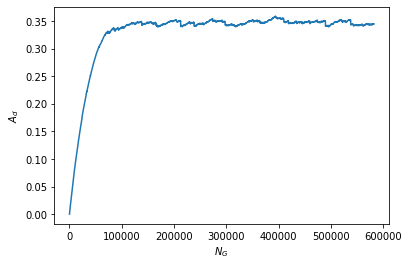

11
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.991116
r_stat_multiplier              0.498734
min_rim_percentage             0.990895
Name: 0, dtype: float64


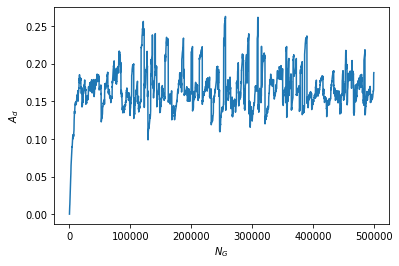

12
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.500548
r_stat_multiplier              0.009682
min_rim_percentage             0.990895
Name: 0, dtype: float64


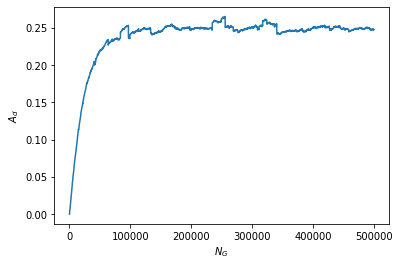

13
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.500548
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


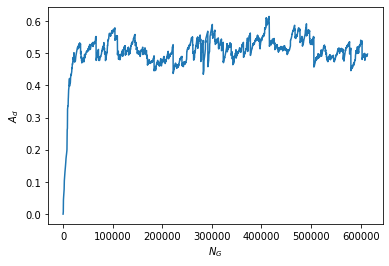

14
Simulation parameters: slope                          0.009327
effective_radius_multiplier    0.009981
r_stat_multiplier              0.009682
min_rim_percentage             0.009747
Name: 0, dtype: float64


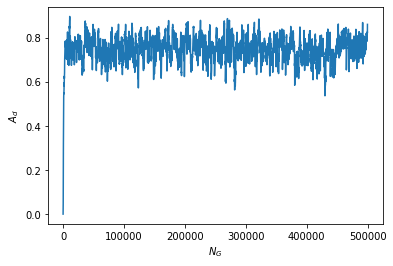

In [21]:
# Visualize CIs for a few in-CCD simulations
alphas = [0.01, 0.05, 0.25, 0.5]
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model, alphas, in_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x)

10
Simulation parameters: slope                          0.737441
effective_radius_multiplier    0.749535
r_stat_multiplier              0.738751
min_rim_percentage             0.828389
Name: 0, dtype: float64


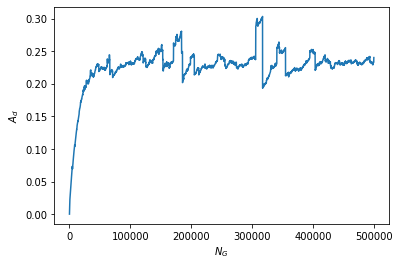

11
Simulation parameters: slope                          0.745171
effective_radius_multiplier    0.747812
r_stat_multiplier              0.252524
min_rim_percentage             0.286815
Name: 0, dtype: float64


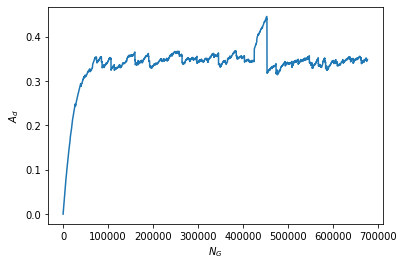

12
Simulation parameters: slope                          0.255893
effective_radius_multiplier    0.743409
r_stat_multiplier              0.741341
min_rim_percentage             0.827450
Name: 0, dtype: float64


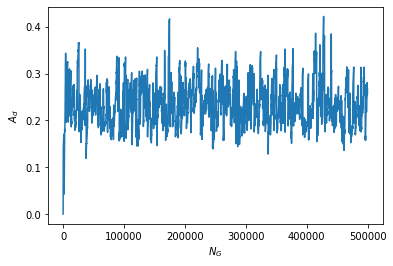

13
Simulation parameters: slope                          0.253586
effective_radius_multiplier    0.745832
r_stat_multiplier              0.254208
min_rim_percentage             0.282288
Name: 0, dtype: float64


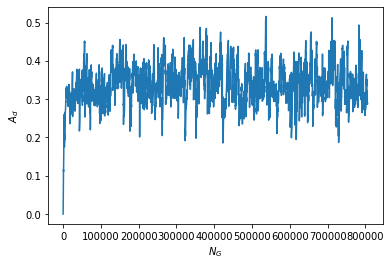

14
Simulation parameters: slope                          0.742547
effective_radius_multiplier    0.257794
r_stat_multiplier              0.257088
min_rim_percentage             0.826457
Name: 0, dtype: float64


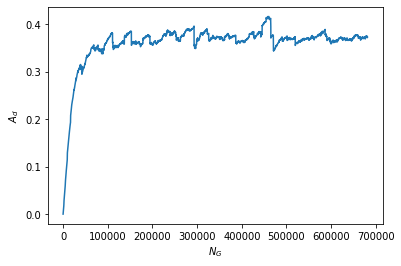

In [22]:
# Visualize CIs for a few simulations outside the CCD
alphas = [0.01, 0.05, 0.25, 0.5]
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model, alphas, outside_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x)

In [23]:
# Report for train data
report_alphas(model, train_df, alphas, metric, lambda x: x)

Alpha = 0.01, % below: 3.42
Alpha = 0.05, % below: 7.29
Alpha = 0.25, % below: 19.94
Alpha = 0.50, % below: 50.53


In [24]:
# Report for in-CCD test sims
report_alphas_for_parquets(model, in_ccd_paths, sample_cadence, alphas, metric, lambda x: x)

Alpha = 0.01, % below: 3.03
Alpha = 0.05, % below: 6.49
Alpha = 0.25, % below: 18.48
Alpha = 0.50, % below: 47.45


In [25]:
# Report for outside-CCD test sims
report_alphas_for_parquets(model, outside_ccd_paths, sample_cadence, alphas, metric, lambda x: x)

Alpha = 0.01, % below: 1.37
Alpha = 0.05, % below: 4.55
Alpha = 0.25, % below: 17.47
Alpha = 0.50, % below: 50.38


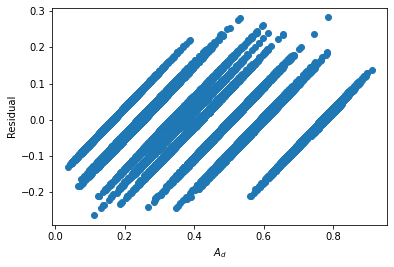

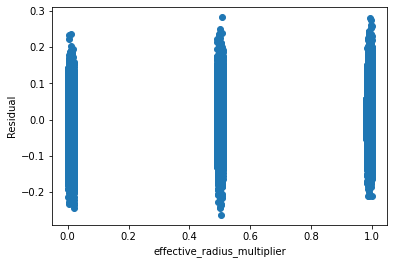

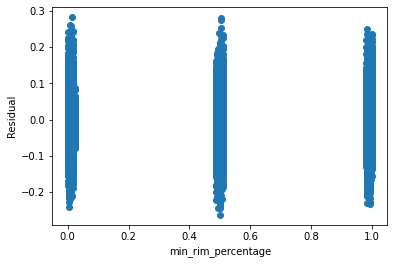

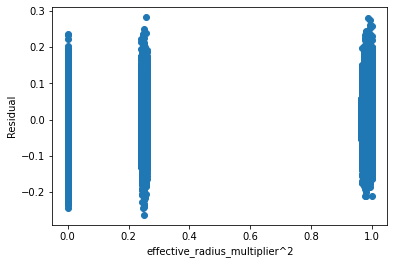

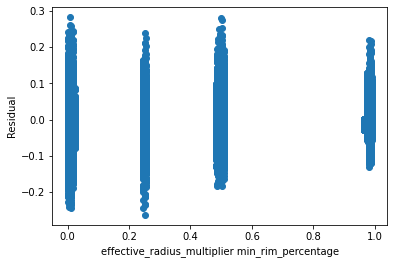

In [26]:
# Model residuals for training data
pred_df = score_model(model, train_df, alphas, metric, lambda x: x)

plt.scatter(pred_df[metric], model.resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in model.model.exog_names:
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], model.resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()